In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import prettyplotlib as ppl
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman'], 'size':14})
rc('text', usetex=True)

In [3]:
# read in dataframe
df = pd.read_csv('final_data_files/all_possible_phot_resid_braga.csv')#_clipped.csv')

# show column names for reference
print df.columns.values

['id' 'ra_x' 'dec_x' 'per' 'mag_v' 'mag_b' 'type' 'mag_j' 'merr_j' 'mag_h'
 'merr_h' 'mag_k' 'merr_k' 'mag_3' 'merr_3' 'mag_4' 'merr_4' 'resid_j'
 'resid_h' 'resid_k' 'resid_3' 'resid_4' 'photfeh' 'photfeh_err' 'ra_y'
 'dec_y' 'per_old' 'per_new' 'feh_s' 'feh_s_err' 'feh_r' 'feh_r_err'
 'feh_rs' 'feh_rs_err' 'feh_b' 'feh_comb' 'feh_comb_err']


In [4]:
dfab = df[df.type == 0]
dfc = df[df.type == 1]

In [5]:
for resid in ['j', 'h', 'k', '3', '4']:
    print '& {:.3f} & {:.3f}'.format(np.std(dfab['resid_{}'.format(resid)]),
                                     np.std(dfc['resid_{}'.format(resid)]))


& 0.204 & 0.112
& 0.312 & 0.252
& 0.273 & 0.169
& 0.574 & 0.360
& 0.335 & 0.374


In [6]:
# get color and color error values
df['color'] = df.mag_3 - df.mag_4
df['color_err'] = np.sqrt(df.merr_3**2 + df.merr_4**2)

In [7]:
# select only rows with non-nan residuals; this is equivalent
# to selecting rows with data in all wavelengths
condition_1 = (np.isfinite(df.resid_3))
# select only rows with non-nan spectroscopic metallicities
condition_2 = (np.isfinite(df.feh_comb))
# select only rows with non-nan photometric metallicities
condition_3 = (np.isfinite(df.photfeh))

condition_4 = (np.isfinite(df.resid_4))

# create new dataframes based on conditions
# star with id=103 is an outlier so we take it out
# and make a new dataframe with it so it's
# excluded from the linear fit but still plottable
df1 = df[condition_1 & condition_2]
df2 = df[condition_1 & condition_3]
df3 = df[condition_4 & condition_2]
df4 = df[condition_4 & condition_3]

# create lists of values for use in the plotting loop
# order is important here
resids = [df1.resid_3, df2.resid_3, df3.resid_4, df4.resid_4]
fehs = [df1.feh_comb, df2.photfeh, df3.feh_comb, df4.photfeh]
resid_errs = [df1.merr_3, df2.merr_3, df3.merr_4, df4.merr_4]
feh_errs = [df1.feh_comb_err, df2.photfeh_err, df3.feh_comb_err, df4.photfeh_err]

dfs = [df1, df2, df3, df4]

def get_type_list(inlist):
    outlist = []
    for i,obj in enumerate(inlist):
        outlist.append(obj[dfs[i].type==0])
    for i,obj in enumerate(inlist):
        outlist.append(obj[dfs[i].type==1])
    outlist = outlist[:2] + outlist[4:6] + outlist[2:4] + outlist[6:]
    return outlist

labels=['RRab, spectroscopic, [3.6]',
        'RRab, photometric, [3.6]',
        'RRab, spectroscopic, [4.5]',
        'RRab, photometric, [4.5]',
        'RRc, spectroscopic, [3.6]',
        'RRc, photometric, [3.6]',
        'RRc, spectroscopic, [4.5]',
        'RRc, photometric, [4.5]']

labels = labels[:2] + labels[4:6] + labels[2:4] + labels[6:]

resids2 = get_type_list(resids)
fehs2 = get_type_list(fehs)
resid_errs2 = get_type_list(resid_errs)
feh_errs2 = get_type_list(feh_errs)

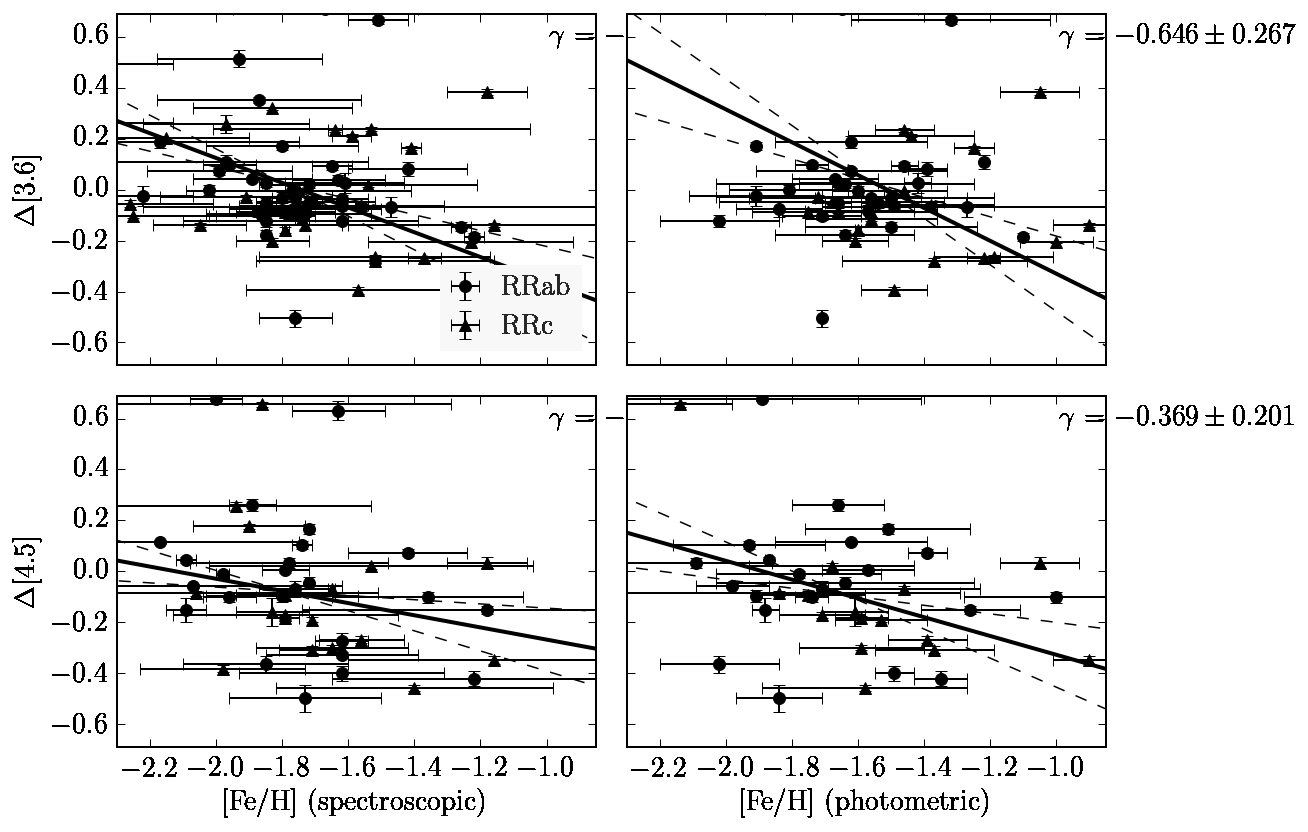

In [8]:
# define line-fitting function
def fitfunc(x,slope,intc):
    return slope*x + intc

# make the figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(8,6))
ax = [ax1, ax2, ax3, ax4]

# plot the things
for i in range(4):
    ax[i].errorbar(fehs[i][dfs[i].type == 0].values, resids[i][dfs[i].type == 0].values,
                   yerr=resid_errs[i][dfs[i].type == 0].values, xerr = feh_errs[i][dfs[i].type == 0].values,
                   fmt='o', color='k', label='RRab')
    ax[i].errorbar(fehs[i][dfs[i].type == 1].values, resids[i][dfs[i].type == 1].values,
                   yerr=resid_errs[i][dfs[i].type == 1].values, xerr = feh_errs[i][dfs[i].type == 1].values,
                   fmt='^', color='k', label='RRc')
    x = np.linspace(-4, 0, 10)
    popt, pcov = curve_fit(fitfunc, fehs[i], resids[i])
    sig = np.sqrt(np.diag(pcov))
    y1 = popt[0] * x + popt[1]
    y2 = (popt[0] + sig[0]) * x + (popt[1] + sig[1])
    y3 = (popt[0] - sig[0]) * x + (popt[1] - sig[1])
    ppl.plot(ax[i],x,y1,'k-',lw=2)
    ppl.plot(ax[i],x,y2,'k--')
    ppl.plot(ax[i],x,y3,'k--')
    ax[i].text(-0.28,0.65,r'$\gamma$ = ${:.3f} \pm {:.3f}$'.format(popt[0], sig[0]),
               va='top', ha='right')
ax3.set_xlabel('[Fe/H] (spectroscopic)')
ax4.set_xlabel('[Fe/H] (photometric)')
ax3.set_ylabel('$\Delta [4.5]$')
ax1.set_ylabel('$\Delta [3.6]$')
ax1.set_ylim(-0.69,0.69)
#ax1.set_xlim(-2.75,-0.25)
ax1.set_xlim(-2.3,-0.85)
ppl.legend(ax1, loc=0, prop={'size':14}, numpoints=1, handlelength=1)
fig.tight_layout()
#fig.savefig('final_plots/metallicity_vs_residuals_m4_clipped.pdf')

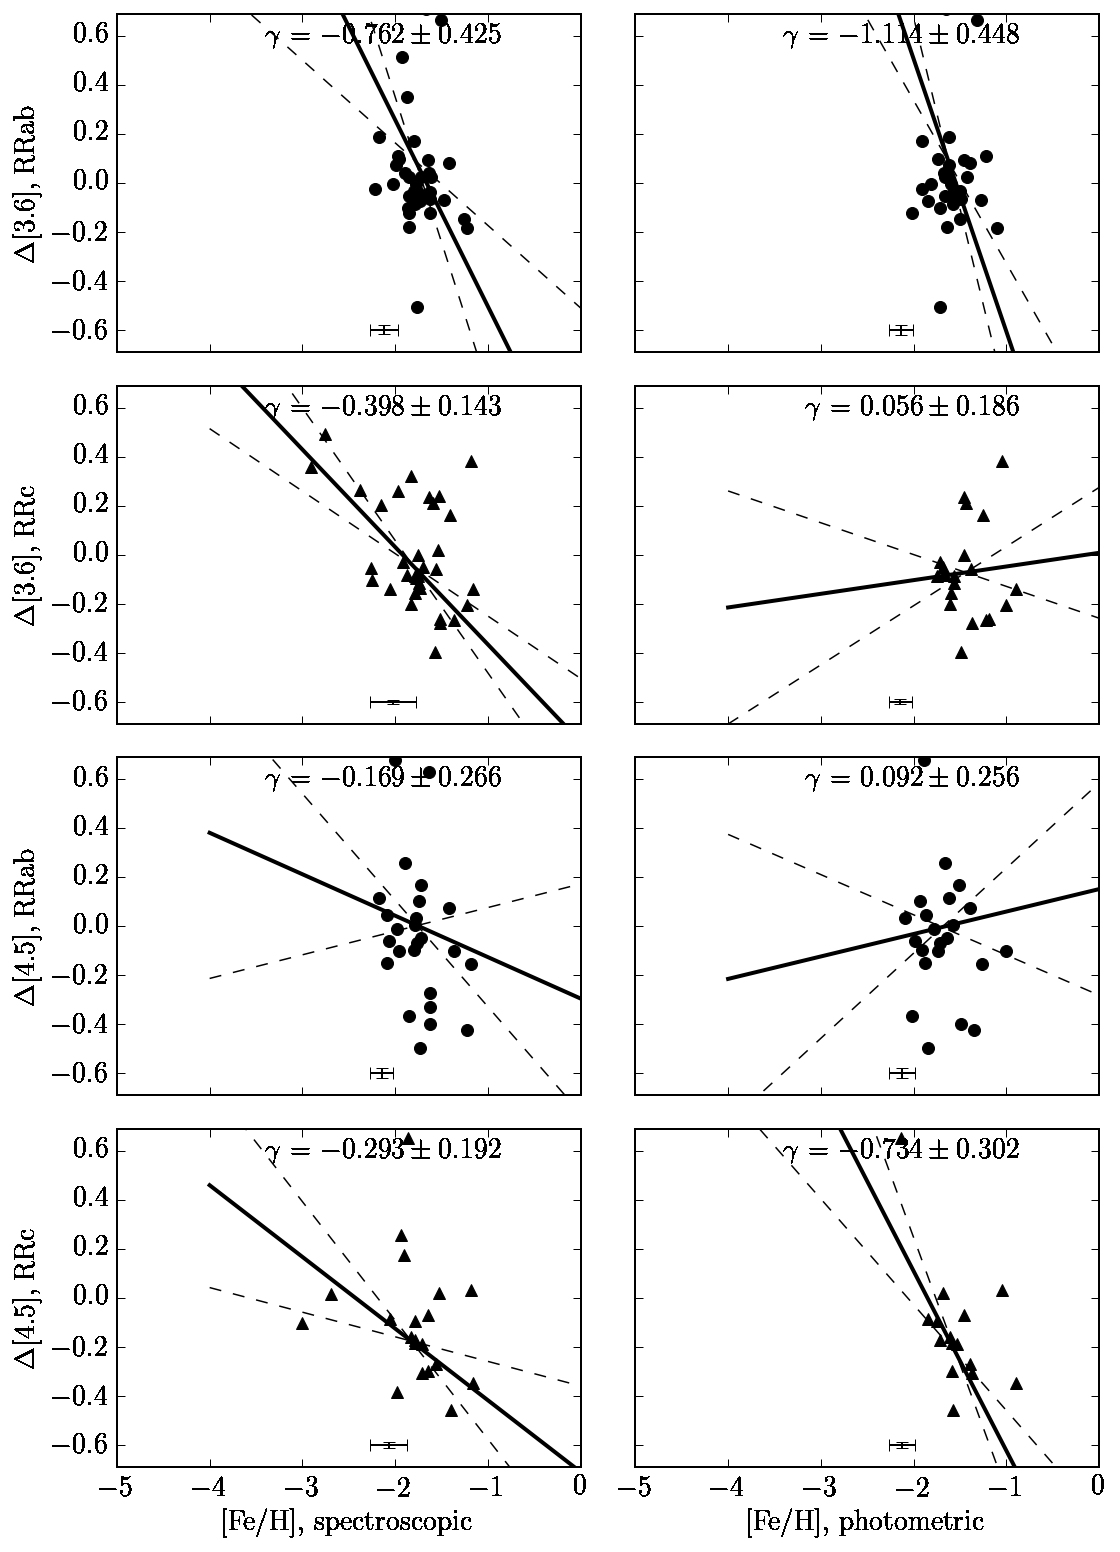

In [9]:
# define line-fitting function
def fitfunc(x,slope,intc):
    return slope*x + intc

# make the figure and subplots
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, sharey=True, sharex=True, figsize=(8,11))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

# plot the things
for i in range(8):
    if labels[i].startswith('RRab'):
        ax[i].plot(fehs2[i].values, resids2[i].values,
                   'ok', label='RRab')
#         ax[i].errorbar(fehs2[i].values, resids2[i].values,
#                        yerr=resid_errs2[i].values, xerr = feh_errs2[i].values,
#                        fmt='o', color='k', label='RRab')
    else:
        ax[i].plot(fehs2[i].values, resids2[i].values,
                   '^k', label='RRc')
#         ax[i].errorbar(fehs2[i].values, resids2[i].values,
#                        yerr=resid_errs2[i].values, xerr = feh_errs2[i].values,
#                        fmt='^', color='k', label='RRc')
    ax[i].errorbar(-2.3 + feh_errs2[i].median() + 0.03,-0.6,
                   yerr=resid_errs2[i].median(),xerr=feh_errs2[i].median(),fmt=',',color='k')
    x = np.linspace(-4, 0, 10)
    popt, pcov = curve_fit(fitfunc, fehs2[i], resids2[i])
    sig = np.sqrt(np.diag(pcov))
    y1 = popt[0] * x + popt[1]
    y2 = (popt[0] + sig[0]) * x + (popt[1] + sig[1])
    y3 = (popt[0] - sig[0]) * x + (popt[1] - sig[1])
    ppl.plot(ax[i],x,y1,'k-',lw=2)
    ppl.plot(ax[i],x,y2,'k--')
    ppl.plot(ax[i],x,y3,'k--')
    ax[i].text(-0.87,0.65,r'$\gamma$ = ${:.3f} \pm {:.3f}$'.format(popt[0], sig[0]),
               va='top', ha='right')
    #ax[i].text(-2,-0.6,labels[i])
ax7.set_xlabel('[Fe/H], spectroscopic')
ax8.set_xlabel('[Fe/H], photometric')
ax1.set_ylabel('$\Delta [3.6]$, RRab')
ax3.set_ylabel('$\Delta [3.6]$, RRc')
ax5.set_ylabel('$\Delta [4.5]$, RRab')
ax7.set_ylabel('$\Delta [4.5]$, RRc')
ax1.set_ylim(-0.69,0.69)
#ax1.set_xlim(-2.75,-0.25)
#ax1.set_xlim(-2.3,-0.85)

ax1.plot(-5,-5,'^k', label='RRc') #legend hackery
#ax1.errorbar(-5,-5,'^k', label='RRc') #legend hackery

#ppl.legend(ax1, loc='lower right', prop={'size':14}, numpoints=1, handlelength=1)
fig.tight_layout()
fig.subplots_adjust(hspace=0.1)
#fig.savefig('final_plots/metallicity_vs_residuals_m4_split.pdf')

In [ ]:
df1_ab = df1[df1.type == 0]
df1_c = df1[df1.type == 1]
df2_ab = df2[df2.type == 0]
df2_c = df2[df2.type == 1]

print 'Type       mean [Fe/H]     num data points'
print 'Spect_all'.ljust(10), str(np.mean(df1.spectfeh)).ljust(15), len(df1.spectfeh)
print 'Spect_ab'.ljust(10), str(np.mean(df1_ab.spectfeh)).ljust(15), len(df1_ab.spectfeh)
print 'Spect_c'.ljust(10), str(np.mean(df1_c.spectfeh)).ljust(15), len(df1_c.spectfeh)
print 'Phot_all'.ljust(10), str(np.mean(df2.photfeh)).ljust(15), len(df2.photfeh)
print 'Phot_ab'.ljust(10), str(np.mean(df2_ab.photfeh)).ljust(15), len(df2_ab.photfeh)
print 'Phot_c'.ljust(10), str(np.mean(df2_c.photfeh)).ljust(15), len(df2_c.photfeh)

In [ ]:
# period color plot

df5 = df[condition_1 & condition_4]

df5_ab = df5[df5.type == 0]
df5_c = df5[df5.type == 1]

color='#AAAAAA'

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
# hack to style plot with prettyplotlib
ppl.plot(ax, [],[])
# actual plotting
ax.errorbar(np.log10(df5_ab.per.values), df5_ab.color.values,
            yerr = df5_ab.color_err.values, fmt='o', color='k',
            label='RRab')
ax.errorbar(np.log10(df5_c.per.values), df5_c.color.values,
            yerr = df5_c.color_err.values, fmt='^', color='k',
            label='RRc')
ax.set_xlabel('$\log P$')
ax.set_ylabel('[3.6] - [4.5]')
ax.set_xlim(-0.63, 0.02)
ax.set_ylim(-0.5, 0.5)
ppl.legend(ax, loc='lower right', prop={'size':14}, numpoints=1, handlelength=1)
fig.tight_layout()
fig.savefig('final_plots/period_color.pdf')

In [ ]:
# metallicity color plot

df6 = df[condition_2]

df6_ab = df6[df6.type == 0]
df6_c = df6[df6.type == 1]

df7 = df[condition_3]

df7_ab = df7[df7.type == 0]
df7_c = df7[df7.type == 1]

color='#AAAAAA'

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(6,7),sharex=True,sharey=True)
# hack to style plot with prettyplotlib
ppl.plot(ax1, [],[])
ppl.plot(ax2, [],[])
# actual plotting
ax1.errorbar(df6_ab.spectfeh.values, df6_ab.color.values,
             xerr = df6_ab.spectfeh_err.values,
             yerr = df6_ab.color_err.values, fmt='o', color='k',
             label='RRab')
ax1.errorbar(df6_c.spectfeh.values, df6_c.color.values,
             xerr = df6_c.spectfeh_err.values,
             yerr = df6_c.color_err.values, fmt='^', color='k',
             label='RRc')
ax2.errorbar(df7_ab.photfeh.values, df7_ab.color.values,
             xerr = df7_ab.photfeh_err.values,
             yerr = df7_ab.color_err.values, fmt='o', color='k',
             label='RRab')
ax2.errorbar(df7_c.photfeh.values, df7_c.color.values,
             xerr = df7_c.photfeh_err.values,
             yerr = df7_c.color_err.values, fmt='^', color='k',
             label='RRc')
ax2.set_xlabel('[Fe/H]')
ax1.text(-0.3,0.45,'Spectroscopic [Fe/H]',ha='right',va='top')
ax2.text(-0.3,0.45,'Photometric [Fe/H]',ha='right',va='top')
ax1.set_ylabel('[3.6] - [4.5]')
ax2.set_ylabel('[3.6] - [4.5]')
ax1.set_xlim(-2.75,-0.25)
ax1.set_ylim(-0.5,0.5)
ppl.legend(ax1, loc=4, prop={'size':14}, numpoints=1, handlelength=1)
fig.tight_layout()
fig.savefig('final_plots/metallicity_color.pdf')

In [ ]:
print np.mean(df.spectfeh)